Name: Rohan Tuli <br>
Candidate number: 245309 <br>
Course: M.Sc in Artificial Intelligence and Adaptive Systems

In [449]:
import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import LFR
from aif360.algorithms.preprocessing.disparate_impact_remover import DisparateImpactRemover
import pdb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.model_selection import KFold
np.random.seed(0)
from sklearn.model_selection import cross_val_score, cross_validate
import itertools
from IPython.display import Markdown, display
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.inprocessing import AdversarialDebiasing, ARTClassifier, GerryFairClassifier, MetaFairClassifier, ExponentiatedGradientReduction
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification
from tqdm import tqdm
import copy as cp
import matplotlib.pyplot as plt
%matplotlib inline
from aif360.sklearn.datasets import fetch_adult,fetch_german

Loading and pre-processing the data

In [7]:
def loading_datasets():
    """
        Function for loading the German and Adult Datasets
    :return: training Adult (70%) and testing Adult (30%),
             training German (70%) and testing German(30%)
    """
    
    # loading the Adult dataset using the AIF360 pre-processing function
    adult_dataset = load_preproc_data_adult(['sex'])
    
    # splitting the data in to a 70-30 ratio while shuffling it
    train_adult, test_adult = adult_dataset.split([0.7], shuffle=True)
    
    # loading the German dataset using the AIF360 pre-processing function
    german_dataset = load_preproc_data_german(["sex"])
    
    # splitting the data into 70-30 ratio while shuffling it
    train_german, test_german = german_dataset.split([0.7], shuffle=True)
    
    return train_adult, test_adult, train_german, test_german 

def scale_train_test(train, test):
    """
        Function to scale the data
    :param train: training data
    :param test: testing data
    :return: scaled training features, scaled training labels, scaled testing features, 
             scaled testing labels, AIF360 scaled training data and
             AIF360 scaled training data
    """
    
    # using standard scaler for scaling the data
    scale = StandardScaler()
    
    # fitting the training features
    scale.fit(train.features)
    
    # tranforming the training features and labels, and testing
    # features and labels.
    X_train = scale.transform(train.features)
    y_train = train.labels
    train_scaled = train.copy()
    train_scaled.features = X_train
    
    X_test = scale.transform(test.features)
    y_test = test.labels.ravel()
    test_scaled = test.copy()
    test_scaled.features = X_test
    
    return X_train, y_train, X_test, y_test, train_scaled, test_scaled

In [8]:
train_adult, test_adult, train_german, test_german = loading_datasets()

# protected attributes
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

X_train_adult, y_train_adult, X_test_adult, y_test_adult, train_adult_scaled, test_adult_scaled = scale_train_test(train_adult, test_adult)
X_train_german, y_train_german, X_test_german, y_test_german, train_german_scaled, test_german_scaled = scale_train_test(train_german, test_german)

In [56]:
# defining the parameters for cross validation
rf_param = {
    "randomforestclassifier__n_estimators" : [50, 100, 500],
    "randomforestclassifier__max_depth" : [5, 10, 20, 50],
    "randomforestclassifier__min_samples_split" : [20, 50, 100],
    "randomforestclassifier__criterion" : ["gini", "entropy"],
}

# Task 1

In [13]:
# class for the first task

class models:
    def __init__(self, X_train, y_train, X_test, y_test, train_scaled, test_scaled, privileged_groups, unprivileged_groups):
        """
            Initialization function
        :param X_train: training features
        :param y_train: training labels
        :param X_test: testing features
        :param y_test: testing labels
        :param train_scaled: AIF360 scaled training data
        :param test_scaled: AIF360 scaled testing data
        :param privileged_groups: list of dict containing the privileged groups
        :param unprivileged_groups: list of dict containing the unprivileged groups
        """
        
        # initialising the values
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_scaled = train_scaled
        self.test_scaled = test_scaled
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups
        
    def random_forrest_train(self, rf_params):
        """
            Function to cross validate based on the hyperparameters
        :param rf_params: parameters for cross validation
        :return: None
        """
        
        # using a seed value for reproducibility
        np.random.seed(0)
        
        # variable strong the results
        self.data_rf = []
        self.params = rf_params
        
        # defining the number of folds
        kf = KFold(n_splits=5)
        
        # finding all combinations of hyperparameters to be tested
        params_ = list(itertools.product(*list(self.params.values())))
        
        # loop for retreiving all hyperparameters
        for (n_estimators_, max_depth_, min_samples_split_, criterion_) in params_:
            
            # local variable for storing each pass
            local_data = []
            
            # dividing the data into train and validation splits
            for train_index, test_index in kf.split(self.train_scaled.features):
                
                # seperating the training and validation data
                training_data = self.train_scaled.subset(train_index)
                validation_data = self.train_scaled.subset(test_index)
                
                # defining the classifier based on the hyperparameters
                classifier = RandomForestClassifier(n_estimators = n_estimators_,
                                                    max_depth = max_depth_, 
                                                    min_samples_split = min_samples_split_,
                                                    criterion = criterion_)
                
                # training the classifier
                classifier.fit(training_data.features, training_data.labels.ravel(), sample_weight=training_data.instance_weights)
                
                # predictions on the validation set
                validation_preds = classifier.predict(validation_data.features)
                
                # creating an AIF360 dataset to pass into the ClassificationMetric
                pred_validation = validation_data.copy()
                pred_validation.labels = validation_preds
                
                fairness_metrics_train = ClassificationMetric(validation_data, 
                                                              pred_validation, 
                                                              unprivileged_groups=unprivileged_groups, 
                                                              privileged_groups=privileged_groups)
                
                # calculating and storing the accuracy and fairness metric
                local_data.append([fairness_metrics_train.accuracy(), 
                                   fairness_metrics_train.equal_opportunity_difference()])
            
            # locally storting the hyperparameters and their respective metrics
            temp = [n_estimators_, max_depth_, min_samples_split_, criterion_]
            temp.extend(np.mean(local_data, axis=0))
            self.data_rf.append(temp)
        cols_train = ["number of estimators", "max depth", 
                      "min samples split", "criterion", 
                      "accuracy", "equal opportunity diff"]
        
        # training results
        self.results_training = pd.DataFrame(self.data_rf, columns = cols_train)
        print("Training results: \n")
        display(self.results_training)
        
    def random_forest_test(self):
        """
            Function for testing the model based on the best accuracy and 
            fairness metrics.
        :return: None
        """
        
        # defining the measures to test the model for
        measures = ["accuracy", "equal opportunity diff"]
        models_test = {}
        
        # loop for testing the measures
        for measure in measures:
            
            # retreiving the parameters based on the measure
            params = self.get_params(measure=measure)
            
            # creating the classifier
            classifier = RandomForestClassifier(n_estimators = int(params[0]),
                                                max_depth = int(params[1]), 
                                                min_samples_split = int(params[2]),
                                                criterion=str(params[3]))
            
            # training and testing the classifier
            classifier.fit(self.X_train, self.y_train)
            preds = classifier.predict(self.X_test)

            # creating a AIF360 dataset for calculating the metrics
            test_predicted = self.test_scaled.copy()
            test_predicted.labels = preds

            fairness_metrics_test_acc = ClassificationMetric(self.test_scaled, 
                                                             test_predicted, 
                                                             unprivileged_groups=unprivileged_groups, 
                                                             privileged_groups=privileged_groups)

            # storing the hyperparameters and metrics of the models
            models_test[f"best {measure}"] = [int(params[0]),
                                              int(params[1]),
                                              int(params[2]),
                                              str(params[3]),
                                              fairness_metrics_test_acc.accuracy(),  
                                              fairness_metrics_test_acc.equal_opportunity_difference()]

    
        cols = ["number of estimators", "max depth", 
                "min samples split", "criterion", 
                "accuracy", "equal opportunity diff"]
        
        # testing results
        testing_performance = pd.DataFrame.from_dict(models_test, orient='index', columns = cols)
        print("\nTesting results: \n")
        display(testing_performance)
        
    def get_params(self, measure):
        """
            Function returning the best parameters based on the measure.
        :param measure: measure to calculate the best parameter
        """
        idx = self.results_training[measure].idxmax()
        row = self.results_training.iloc[idx]
        params = row[["number of estimators", "max depth", "min samples split", "criterion"]].values.tolist()
        return params

## German dataset

In [465]:
# initialising the German dataset for training
model_german = models(X_train_german, y_train_german,
                      X_test_german, y_test_german,
                      train_german_scaled, test_german_scaled,
                      privileged_groups, unprivileged_groups)

# training the model
model_german.random_forrest_train(rf_param)

# testing the model
model_german.random_forest_test()

Training results


,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
0,50,5,20,gini,0.692857,-0.130477
1,50,5,20,entropy,0.702857,-0.094136
2,50,5,50,gini,0.702857,-0.094038
3,50,5,50,entropy,0.692857,-0.138439
4,50,5,100,gini,0.692857,-0.069803
...,...,...,...,...,...,...
67,500,50,20,entropy,0.691429,-0.170552
68,500,50,50,gini,0.680000,-0.151544
69,500,50,50,entropy,0.682857,-0.161544
70,500,50,100,gini,0.694286,-0.074866



Testing results: 



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
best accuracy,100,5,20,entropy,0.723333,-0.078125
best equal opportunity diff,50,5,100,entropy,0.723333,-0.062500


## Adult dataset

In [15]:
# initialising the Adult dataset for training
model_adult = models(X_train_adult, y_train_adult,
                      X_test_adult, y_test_adult,
                      train_adult_scaled, test_adult_scaled,
                      privileged_groups, unprivileged_groups)

# training the model
model_adult.random_forrest_train(rf_param)

# testing the model
model_adult.random_forest_test()

Training results: 



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
0,50,5,20,gini,0.799351,-0.390255
1,50,5,20,entropy,0.803650,-0.451132
2,50,5,50,gini,0.801954,-0.423261
3,50,5,50,entropy,0.803416,-0.450823
4,50,5,100,gini,0.802539,-0.440682
...,...,...,...,...,...,...
91,1000,50,20,entropy,0.802890,-0.471399
92,1000,50,50,gini,0.802627,-0.468529
93,1000,50,50,entropy,0.802744,-0.468965
94,1000,50,100,gini,0.803007,-0.466492



Testing results: 



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
best accuracy,100,10,50,gini,0.803863,-0.435017
best equal opportunity diff,100,5,100,gini,0.797175,-0.302694


# Task 2

In [38]:
# pre-processing
def reweighing(train, test, privileged_groups, unprivileged_groups):
    """
        Function for applying reweighing (pre-processing)
    :param train: training data
    :param test: testing data
    :param privileged_groups: privileged group of individuals
    :param unprivileged_groups: unprivileged_groups group of individuals
    :return: reweighed training and testing data
    """
    
    # instantiating the reweighing class
    RW = Reweighing(unprivileged_groups = unprivileged_groups,
                    privileged_groups = privileged_groups)
    
    # training the model
    RW.fit(train)
    
    # training and testing the models
    train_RW = RW.transform(train)
    test_RW = RW.transform(test)
    return train_RW, test_RW

def disparate_impact_remover(train, test):
    """
        Function for applying Disparate Impact Removal (pre-processing)
    :param train: training data
    :param test: testing data
    :return: training data and testing data after transformation
    """
    
    # instantiating the DIR class with a repair level of 1
    di = DisparateImpactRemover(repair_level=1.0)
    
    # transforming the data
    train_DIR = di.fit_transform(train)
    test_DIR = di.fit_transform(test)
    return train_DIR, test_DIR

# in-processing
def exp_grad_red(estimator, training_data, testing_data, constraints="EqualizedOdds"):
    """
        Function to implement Exponentiated Gradient Reduction
    :param estimator: Random Forest classifier
    :training_data: training data:
    :testing_data: testing data
    :constraints: contrainst to use (default: "EqualizedOdds")
    :return: fair data after inprocessing
    """
    
    # instantiating the class
    exp_grad_red_ = ExponentiatedGradientReduction(estimator=estimator,
                                                   constraints=constraints,
                                                   drop_prot_attr=False)
    
    # training
    exp_grad_red_.fit(training_data)
    
    # prediction
    exp_grad_red_pred = exp_grad_red_.predict(testing_data)
    return exp_grad_red_pred

# post-processing
def CEOP(original_data, predicted_data, privileged_groups, unprivileged_groups):
    """
        Function to implement equalised odds post-processing
    :param original_data: original biased data
    :param predicted_data: data after making the predictions
    :param privileged_groups: privileged group of individuals
    :param unprivileged_groups: unprivileged_groups group of individuals
    :return: post-processed data
    """
    randseed = 0
    
    # post processing method
    cpp = EqOddsPostprocessing(privileged_groups = privileged_groups,
                               unprivileged_groups = unprivileged_groups,
                               seed=randseed)
    
    # training
    cpp = cpp.fit(original_data, predicted_data)
    
    # prediction
    predicted_data = cpp.predict(predicted_data)
    return predicted_data

# class for implementing the ensemble fairness method
class emsemble:
    def __init__(self, X_train, y_train, X_test, y_test, train_scaled, test_scaled, privileged_groups, unprivileged_groups):
        """
            Initialization function
        :param X_train: training features
        :param y_train: training labels
        :param X_test: testing features
        :param y_test: testing labels
        :param train_scaled: AIF360 scaled training data
        :param test_scaled: AIF360 scaled testing data
        :param privileged_groups: list of dict containing the privileged groups
        :param unprivileged_groups: list of dict containing the unprivileged groups
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_scaled = train_scaled
        self.test_scaled = test_scaled
        self.privileged_groups = privileged_groups
        self.unprivileged_groups = unprivileged_groups
        self.train = self.train_scaled
        self.test = self.test_scaled
        self.training_results=[]
        self.model_names = ["ensemble"]
        self.cols = ["number of estimators", "max depth", 
                     "min samples split", "criterion", 
                     "accuracy", "equal opportunity diff"]
    
    def ensemble_model(self, rf_params):
        """
            Function to create and train the ensemble model
        :param rf_params: hyperparameters to train the model
        :return: None
        """
        # setting a seed value for reproducibility
        np.random.seed(0)
        
        # results from the ensemble method
        self.data_ensemble=[]
        self.params=rf_params
        
        # defining the number of folds
        kf=KFold(n_splits=5)
        
        # combination of parameters
        params_ = list(itertools.product(*list(self.params.values())))
        
        # loop to train the model on different parameters
        for (n_estimators_, max_depth_, min_samples_split_, criterion_) in params_:
            
            # local data
            local_data_ensemble=[]
            
            # loop for splitting data into training and validation
            for train_index, test_index in kf.split(self.train.features):
                
                # obtaining the training and validation data
                training_data = self.train.subset(train_index)
                validation_data = self.train.subset(test_index)
                
                # ensemble (preprocessing followed by inprocessing followed by postprocessing)        
                
                # 1. Pre-processing (Disparate Impact Remover)
                training_data_preproc, validation_data_preproc = disparate_impact_remover(training_data, validation_data)
                classifier = RandomForestClassifier(n_estimators = n_estimators_,
                                                    max_depth = max_depth_, 
                                                    min_samples_split = min_samples_split_,
                                                    criterion = criterion_)
                
                # 2. In-processing (Exponentiated Gradient Reduction)
                pred_validation_ensemble = exp_grad_red(classifier, training_data_preproc, validation_data_preproc)
                
                # 3. Post-processing (Equalised Odds)
                pred_validation_ensemble = CEOP(validation_data_preproc, pred_validation_ensemble, unprivileged_groups=self.unprivileged_groups, privileged_groups=self.privileged_groups)
                temp = validation_data.copy()
                temp.labels = pred_validation_ensemble.labels
                
                # metrics
                fm_ensemble = ClassificationMetric(validation_data, 
                                                   temp, 
                                                   unprivileged_groups=self.unprivileged_groups, 
                                                   privileged_groups=self.privileged_groups)
                
                # storing the metrics
                local_data_ensemble.append([fm_ensemble.accuracy(), 
                                            fm_ensemble.equal_opportunity_difference()])

            parameters_ = [n_estimators_, max_depth_, min_samples_split_, criterion_]

            ensemble = cp.copy(parameters_)
            ensemble.extend(np.mean(local_data_ensemble, axis=0))
            self.data_ensemble.append(ensemble)
        
        # ensemble results
        self.results_ensemble = pd.DataFrame(self.data_ensemble, columns = self.cols)
        
        self.training_results.extend([self.results_ensemble])
        self.models_train = {model_name:model_df for (model_name, model_df) in zip(self.model_names, self.training_results)}
        
    def model_testing(self):
        """
            Function to test the model based on the measure
        :return: None
        """
        
        # defining the measures
        measures = ["accuracy", "equal opportunity diff"]
        models_test = {}
        
        # loop through the model
        for method_, model_name in zip(self.training_results, self.model_names):
            
            # storing the results
            models_test[model_name] = {}
            for measure in measures:
                
                # retreiving the best measures
                params = self.get_params(method_, measure=measure)
                
                # Pre-processing
                training_data_preproc, testing_data_preproc = disparate_impact_remover(self.train_scaled, self.test_scaled)
                
                # ensemble (pre-processing - inprocessing - postprocessing)
                if model_name == "ensemble":
                    
                    # inprocessing
                    classifier_ensemble = RandomForestClassifier(n_estimators = int(params[0]),
                                                                 max_depth = int(params[1]), 
                                                                 min_samples_split = int(params[2]),
                                                                 criterion=str(params[3]))
                
                    pred_testing_ensemble = exp_grad_red(classifier_ensemble, training_data_preproc, testing_data_preproc)
                    
                    # post-processing
                    pred_testing_ensemble = CEOP(testing_data_preproc, pred_testing_ensemble, unprivileged_groups=self.unprivileged_groups, privileged_groups=self.privileged_groups)
                    
                    # metrics calculation
                    temp = self.test_scaled.copy()
                    temp.labels = pred_testing_ensemble.labels
                    models_test[model_name][f"best {measure}"] = self.calc_metrics(self.test_scaled, temp, params)
        
        # storing the data
        self.models_test = {}
        for (model_name, data) in models_test.items():
            self.models_test[model_name] = pd.DataFrame.from_dict(data, orient='index', columns = self.cols)
        
    def calc_metrics(self, orig, predicted, params):
        """
            Function to calculate the metrics
        :param orig: biased data
        :param predicted: data after processing
        :param params: hyperparameters
        :return: list of hyperparameters and metrics
        """
        
        # classification metric
        fairness_metrics_test_acc = ClassificationMetric(orig, 
                                                         predicted, 
                                                         unprivileged_groups=self.unprivileged_groups, 
                                                         privileged_groups=self.privileged_groups)
        return [int(params[0]),
                int(params[1]),
                int(params[2]),
                str(params[3]),
                fairness_metrics_test_acc.accuracy(), 
                fairness_metrics_test_acc.equal_opportunity_difference()]
        
    def get_params(self, model, measure):
        """
            Function to retreive the parameters based on the measure
        :param model: model to choose the parameter
        :param measure: accuracy or fairness
        """
        
        # returning the best accuracy
        if measure == "accuracy":
            idx = model[measure].idxmax()
            row = model.iloc[idx]
            params = row[["number of estimators", "max depth", "min samples split", "criterion"]].values.tolist()
            return params
        
        # returning the best fairness
        else:
            idx = model[measure].abs().idxmin()
            row = model.iloc[idx]
            params = row[["number of estimators", "max depth", "min samples split", "criterion"]].values.tolist()
            return params
        
    def display_results(self):
        """
            Displaying the results
        :return: None
        """
        for model_name in self.model_names:
            print(f"Method: {model_name}\n")
            print("Training results:")
            display(self.models_train.get(model_name))
            print("\nTesting results:")
            display(self.models_test.get(model_name))
            print("\n\n")

## German dataset

In [489]:
# Initialising the data for task 2 - German dataset
ensemble_german = emsemble(X_train_german, y_train_german,
                           X_test_german, y_test_german,
                           train_german_scaled, test_german_scaled,
                           privileged_groups, unprivileged_groups)
ensemble_german.ensemble_model(rf_param)
ensemble_german.model_testing()
ensemble_german.display_results()

Method: ensemble

Training results:



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
0,50,5,20,gini,0.565714,-0.033101
1,50,5,20,entropy,0.537143,-0.016880
2,50,5,50,gini,0.554286,-0.021517
3,50,5,50,entropy,0.570000,-0.056180
4,50,5,100,gini,0.610000,-0.016521
...,...,...,...,...,...,...
67,500,50,20,entropy,0.410000,-0.061431
68,500,50,50,gini,0.602857,-0.012447
69,500,50,50,entropy,0.532857,-0.001497
70,500,50,100,gini,0.470000,0.045093


Testing results:



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
best accuracy,500,5,50,entropy,0.716667,0.027708
best equal opportunity diff,50,10,100,entropy,0.393333,0.013333


## Adult dataset

In [492]:
# Initialising the data for task 2 - Adult dataset
ensemble_adult = emsemble(X_train_adult, y_train_adult,
                          X_test_adult, y_test_adult,
                          train_adult_scaled, test_adult_scaled,
                          privileged_groups, unprivileged_groups)
ensemble_adult.ensemble_model(rf_param)
ensemble_adult.model_testing()
ensemble_adult.display_results()

Method: ensemble

Training results: 



,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
0,50,5,20,gini,0.778964,0.001958
1,50,5,20,entropy,0.777326,-0.001151
2,50,5,50,gini,0.778730,0.002461
3,50,5,50,entropy,0.778379,0.001502
4,50,5,100,gini,0.777940,0.000949
...,...,...,...,...,...,...
67,500,50,20,entropy,0.783702,0.001468
68,500,50,50,gini,0.784609,0.000212
69,500,50,50,entropy,0.783351,0.001045
70,500,50,100,gini,0.784170,0.001243


Testing results:


,number of estimators,max depth,min samples split,criterion,accuracy,equal opportunity diff
best accuracy,500,20,100,entropy,0.788098,0.006549
best equal opportunity diff,500,5,20,entropy,0.787620,-0.002414


# Task 3
Proposed criterion: $criterion_1 = accuracy - |equal\_opportunity\_difference|$

In [361]:
def add_criterions(dfs):
    """
        Function to add the proposed criterion
    :param dfs: dataframes
    :return: dataframes with added criterion
    """
    # copying the dataframes and adding the criterion
    dfs = cp.deepcopy(dfs)
    for df in dfs:
        df["criterion_1"] = df["accuracy"] - df["equal opportunity diff"].abs()
    return dfs

def criterion_params(df, criterion):
    """
        Function to return the parameters of the chosen criterion
    :param df: dataframe
    :criterion: proposed criterion
    :return: list of hyperparameters
    """
    return df[["number of estimators", "max depth", "min samples split", "criterion"]].iloc[df[criterion].idxmax()].values.tolist()
    
def change_name(d, name):
    """
        Function to change name of dict
    :param d: dictionary
    :param name: name to be changed
    :return: updated dictionary
    """
    return {f"{name}_{key}" : value for (key, value) in d.items()}

cols = ["number of estimators", "max depth", "min samples split", "criterion", "accuracy", "equal opp diff"]

In [362]:
# adding the criterion to the dictionaries

[df_1_german, df_1_adult, df_2_german, df_2_adult] = add_criterions([task_1_german, task_1_adult, task_2_german, task_2_adult])

In [369]:
def task_3(df, train, test, task, unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}]):
    """
        Function to find the best proposed criterion and test the model
    :param train: training data
    :param test: testing data
    :param unprivileged_groups: unprivileged groups
    :param privileged_groups: privileged_groups
    :return: models
    """
    
    # finding the criterions
    params_c1 = criterion_params(df, "criterion_1")
    
    # storing it in a dictionary
    criterions_models = {"criterion_1" : params_c1}
    models={}
    
    # loop for running the respective criterions
    for (criterion_name, params) in criterions_models.items():
        
        # creating the classifier
        classifier = RandomForestClassifier(n_estimators = int(params[0]),
                                            max_depth = int(params[1]), 
                                            min_samples_split = int(params[2]),
                                            criterion=str(params[3]))
        # first task models
        if task == 1:
            
            # using the same testing methodology as task 1
            
            classifier.fit(train.features, train.labels)
            preds = classifier.predict(test.features)
            test_predicted = test.copy()
            test_predicted.labels = preds

            fairness_metrics_test_acc = ClassificationMetric(test, 
                                                             test_predicted, 
                                                             unprivileged_groups=unprivileged_groups, 
                                                             privileged_groups=privileged_groups)

            models[criterion_name] = [int(params[0]),
                                                 int(params[1]),
                                                 int(params[2]),
                                                 str(params[3]),
                                                 fairness_metrics_test_acc.accuracy(),  
                                                 fairness_metrics_test_acc.equal_opportunity_difference()]
        
        # second task models
        elif task == 2:
            
            # using the same testing methodology as task 2
            
            training_DIR, testing_DIR = disparate_impact_remover(train, test)
            pred_testing_ensemble = exp_grad_red(classifier, training_DIR, testing_DIR)
            pred_testing_ensemble = CEOP(testing_DIR, pred_testing_ensemble, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            temp = testing_DIR.copy()
            temp.labels = pred_testing_ensemble.labels
            fairness_metrics_test_acc = ClassificationMetric(testing_DIR, 
                                                             temp, 
                                                             unprivileged_groups=unprivileged_groups, 
                                                             privileged_groups=privileged_groups)

            models[criterion_name] = [int(params[0]),
                                      int(params[1]),
                                      int(params[2]),
                                      str(params[3]),
                                      fairness_metrics_test_acc.accuracy(),  
                                      fairness_metrics_test_acc.equal_opportunity_difference()]
    return models

## Adult Dataset

In [421]:
# storing and displaying the results for the Adult dataset

adult_task_13 = task_3(df_1_adult, train_adult_scaled, test_adult_scaled, 1)
adult_task_23 = task_3(df_2_adult, train_adult_scaled, test_adult_scaled, 2)
adult_task_13 = change_name(adult_task_13, "adult")
adult_task_23 = change_name(adult_task_23, "adult")


pd.concat([pd.DataFrame.from_dict(adult_task_13, orient="index", columns=cols), pd.DataFrame.from_dict(adult_task_23, orient="index", columns=cols)])

,number of estimators,max depth,min samples split,criterion,accuracy,equal opp diff
adult_adult_criterion_1,100,5,100,gini,0.804818,-0.428283
adult_adult_criterion_1,500,20,20,gini,0.786255,0.001963


## German dataset

In [422]:
# storing and displaying the results for the German dataset

german_task_13 = task_3(df_1_german, train_german_scaled, test_german_scaled, 1)
german_task_23 = task_3(df_2_german, train_german_scaled, test_german_scaled, 2)
german_task_13 = change_name(german_task_13, "german")
german_task_23 = change_name(german_task_23, "german")

pd.concat([pd.DataFrame.from_dict(german_task_13, orient="index", columns=cols), pd.DataFrame.from_dict(german_task_23, orient="index", columns=cols)])

,number of estimators,max depth,min samples split,criterion,accuracy,equal opp diff
german_german_criterion_1,50,5,100,entropy,0.713333,0.000000
german_german_criterion_1,500,5,50,gini,0.710000,-0.008958


# Creating graphs

## Accuracy and fairness for each task

In [376]:
def plot_2(df, name, task):
    """
        Function for plotting the accuracy and fairness
    :param df: dataframe
    :param name: name of the dataset
    :param task: task 1 or 2
    :return: None
    """
    
    # finding the best accuracy
    acc = list(df[["accuracy", "equal opportunity diff"]].iloc[df["accuracy"].idxmax()])
    
    # finding the best fairness
    fairness = list(df[["accuracy", "equal opportunity diff"]].iloc[df["equal opportunity diff"].abs().idxmin()])
    acc_ = [acc[0], fairness[0]]
    fairness_ = [acc[1], fairness[1]]

    # plotting the results
    ind = np.arange(2) 
    width = 0.2
    plt.bar(ind, acc_, width, label = "accuracy")
    plt.bar(ind+width, fairness_, width, label = "equal opp diff")
    plt.title(f"{name} dataset cv results")
    plt.ylabel('Metrics')
    plt.xticks(ind + width / 2, ('Highest accuracy', 'Best fairness'))
    plt.legend()
    plt.savefig(f"/Users/rt/Desktop/College/M.Sc/Semester 2/Machine Learning/Assignment/data/task/task_{task}_{name}.png")
    plt.show()

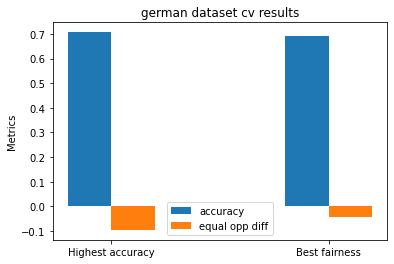

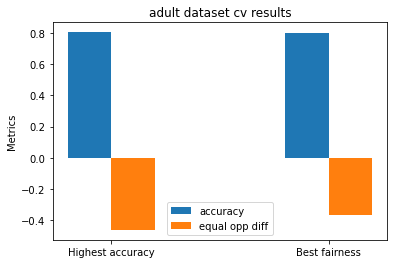

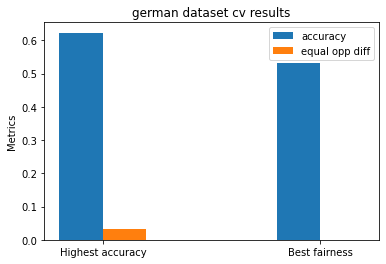

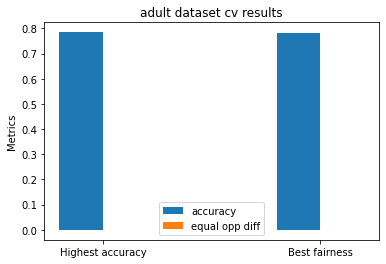

In [377]:
plot_2(task_1_german, "german", 1)
plot_2(task_1_adult, "adult", 1)
plot_2(task_2_german, "german", 2)
plot_2(task_2_adult, "adult", 2)

## Hyperparameter settings for each task

In [426]:
def plot_1(dfs, name, task):
    """
        Function to plot the hyperparameters of all tasks
    :param dfs: dataframes of all tasks
    :param name: name of the dataset
    :param task: task 1 or 2
    :return: None
    """
    cols = ["number of estimators", "max depth", "min samples split", "criterion"]
    
    # looping around the hyperparameters
    for hyperparam in cols:
        hp = dfs[0][hyperparam].unique()
        local_acc_t1 = []
        local_fairness_t1 = []
        local_acc_t2 = []
        local_fairness_t2 = []  
        local_acc_t3 = []
        local_fairness_t3 = []
        local_acc_t4 = []
        local_fairness_t4 = []
        
        # finding the accuracy and fairness for each hyperparameter setting
        for i in hp:
            temp1 = cp.deepcopy(dfs[0])
            temp2 = cp.deepcopy(dfs[1])
            temp3 = cp.deepcopy(dfs[2])
            temp4 = cp.deepcopy(dfs[3])
            
            temp1 = temp1.loc[temp1[hyperparam] == i]
            temp2 = temp2.loc[temp2[hyperparam] == i]
            temp3 = temp3.loc[temp3[hyperparam] == i]
            temp4 = temp4.loc[temp4[hyperparam] == i]
            
            local_acc_t1.append(temp1["accuracy"].mean())
            local_fairness_t1.append(temp1["equal opportunity diff"].mean())
            
            local_acc_t2.append(temp2["accuracy"].mean())
            local_fairness_t2.append(temp2["equal opportunity diff"].mean())
            
            local_acc_t3.append(temp3["accuracy"].mean())
            local_fairness_t3.append(temp3["equal opportunity diff"].mean())

            local_acc_t4.append(temp4["accuracy"].mean())
            local_fairness_t4.append(temp4["equal opportunity diff"].mean())
        
        # plotting the accuracy results
        plt.plot(hp, local_acc_t1, label="German task 1")
        plt.plot(hp, local_acc_t2, label="German task 2")
        plt.plot(hp, local_acc_t3, label="Adult task 1")
        plt.plot(hp, local_acc_t4, label="Adult task 2")
        plt.xlabel(hyperparam)
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs {hyperparam}")
        plt.legend()
        plt.savefig(f"/Users/rt/Desktop/College/M.Sc/Semester 2/Machine Learning/Assignment/data/task_{task}_{name}_{hyperparam}_accuracy.png")
        plt.show()
        
        # plotting the fairness results
        plt.plot(hp, local_fairness_t1, label="German task 1")
        plt.plot(hp, local_fairness_t2, label="German task 2")
        plt.plot(hp, local_fairness_t3, label="Adult task 1")
        plt.plot(hp, local_fairness_t4, label="Adult task 2")
        plt.xlabel(hyperparam)
        plt.ylabel("Equal opp diff")
        plt.title(f"Equal opp diff vs {hyperparam}")
        plt.legend()
        plt.savefig(f"/Users/rt/Desktop/College/M.Sc/Semester 2/Machine Learning/Assignment/data/task_{task}_{name}_{hyperparam}_fairness.png")
        plt.show()

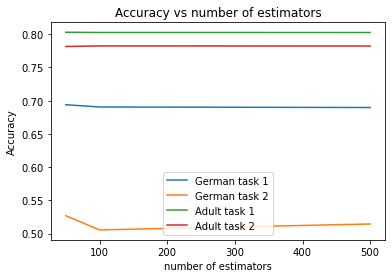

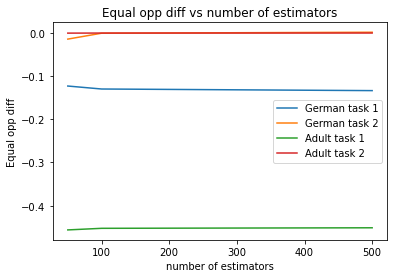

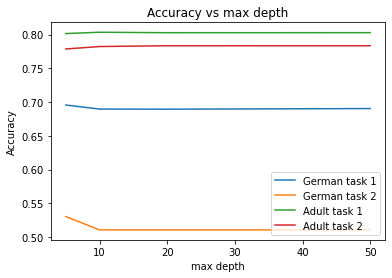

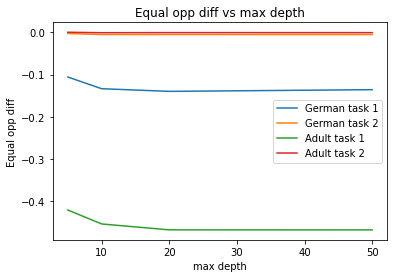

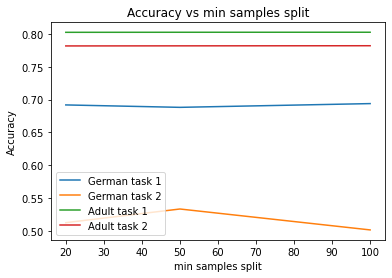

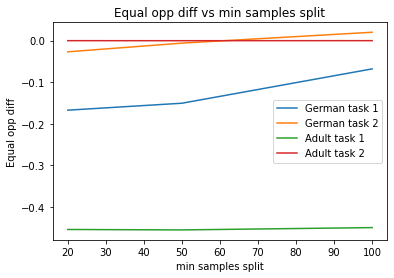

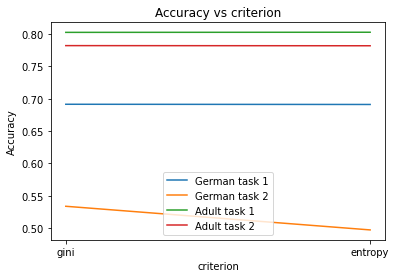

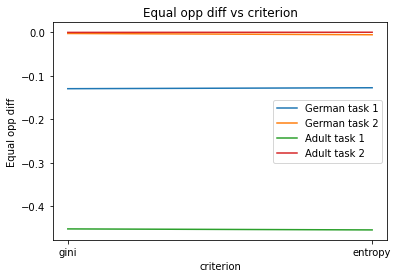

In [428]:
# calling the function
plot_1([task_1_german, task_2_german, task_1_adult, task_2_adult], "german", "combined")

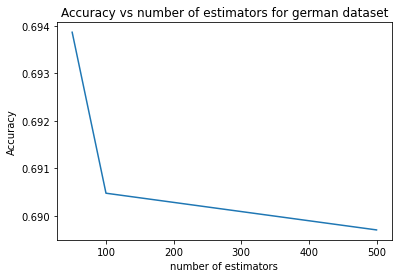

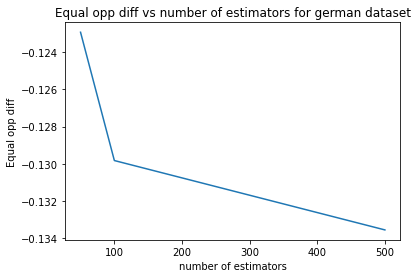

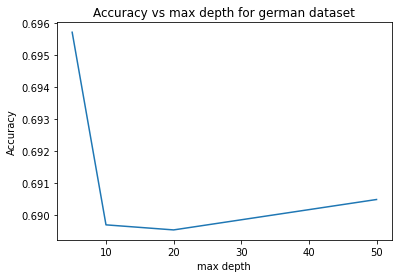

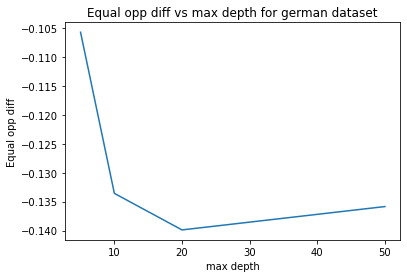

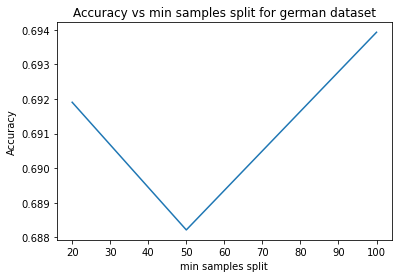

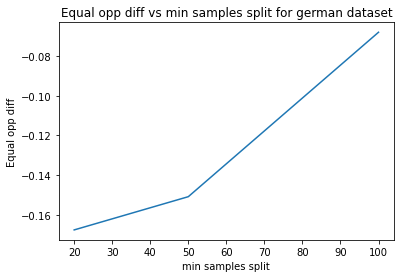

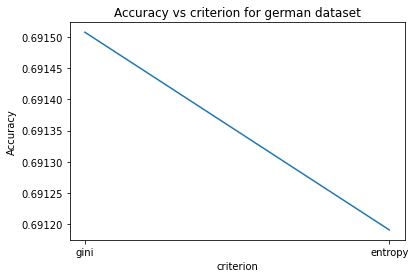

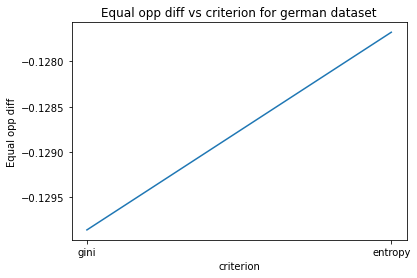

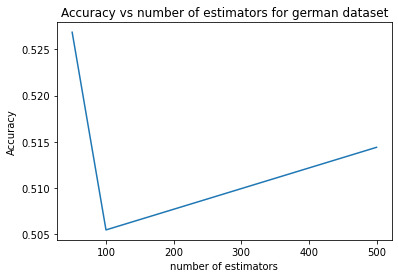

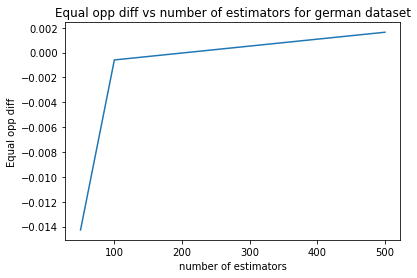

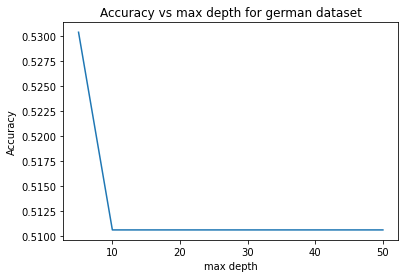

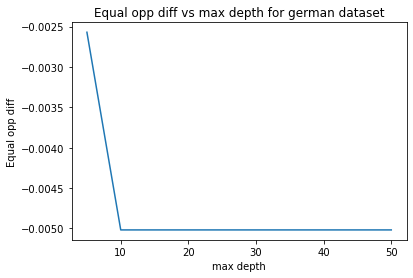

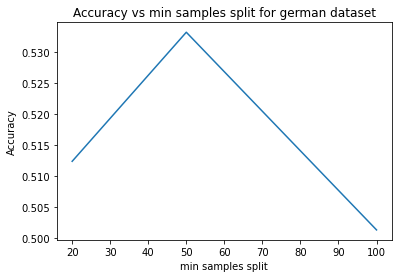

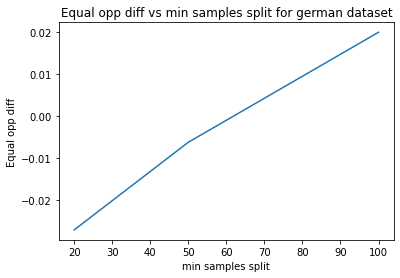

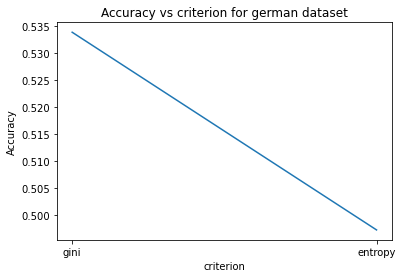

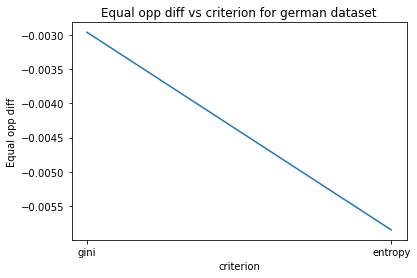

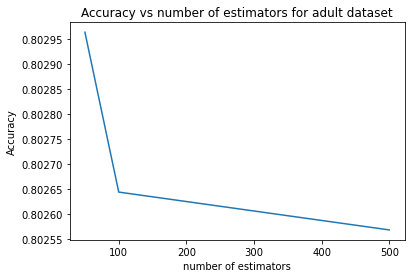

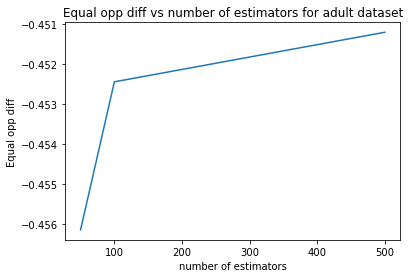

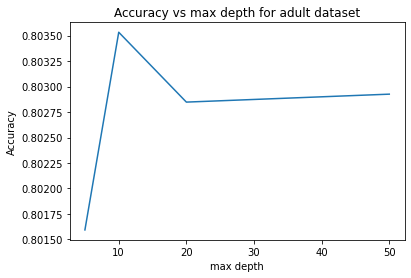

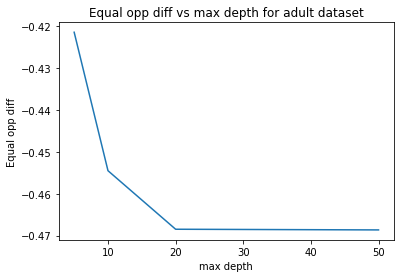

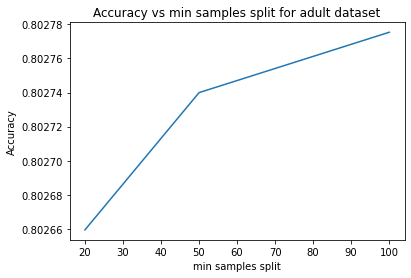

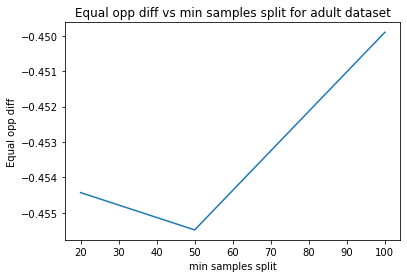

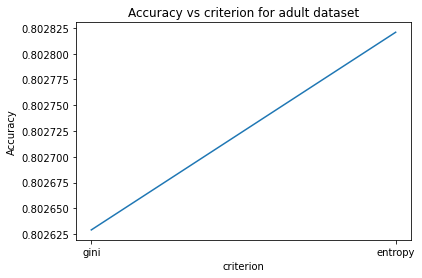

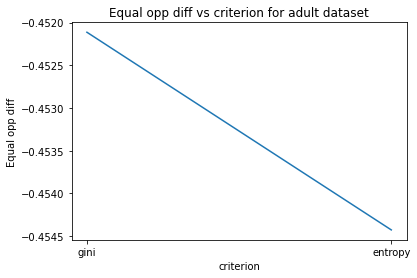

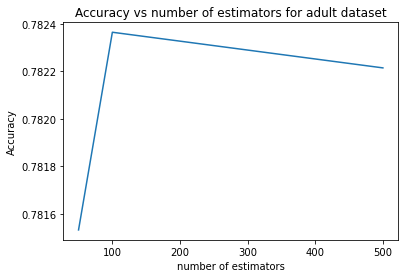

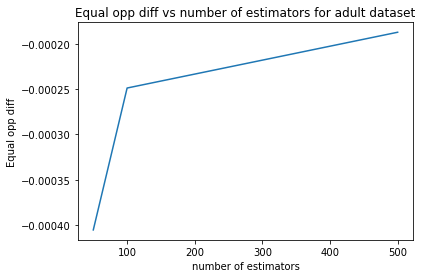

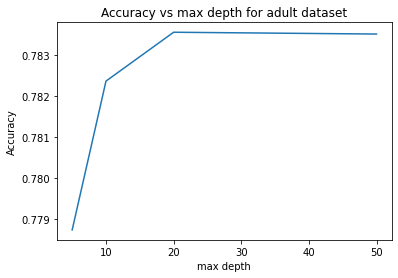

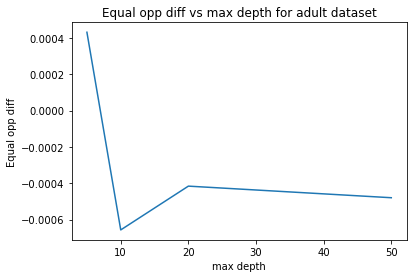

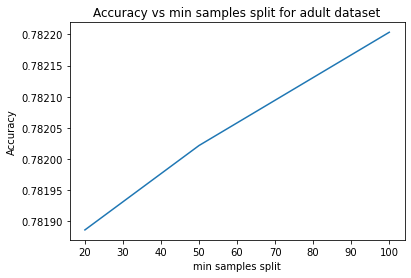

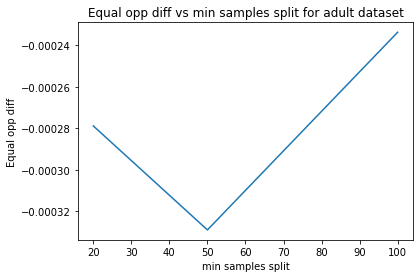

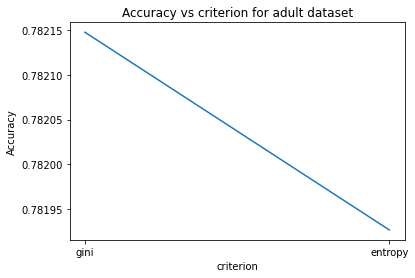

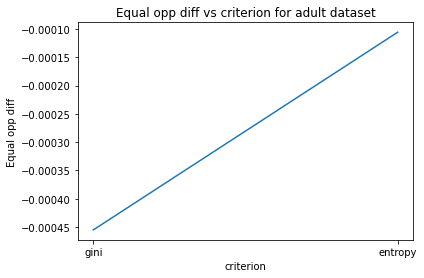

In [379]:
# individual hyperparameters

plot_1(task_1_german, "german", 1)
plot_1(task_2_german, "german", 2)
plot_1(task_1_adult, "adult", 1)
plot_1(task_2_adult, "adult", 2)

# Extension

## Sensitive feature analysis

### Absence of sensitive features

In [494]:
#defining the privileged and unprivileged groups
privileged_groups = [{'sex':1,'race': 1}]
unprivileged_groups = [{'sex':0,'race': 0}]

# loading and splitting the data
dataset_orig = load_preproc_data_adult(['sex','race'])
train, test = dataset_orig.split([0.7], shuffle=True)

# defining the folds
kf = KFold(n_splits=5)
res = []

# hyperparameters
hyperparams = [50, 100, 200, 500]
for hp in hyperparams:
    local_data = []
    
    # looping across the indices
    for (train_index, validation_index) in kf.split(train.features):
        
        # training and validation set
        training = train.subset(train_index)
        validation = train.subset(validation_index)
        
        # scaling the features
        scaler = StandardScaler()
        
        # removing the features
        X_train = scaler.fit_transform(training.features[:,2:])
        y_train = training.labels.ravel()
        
        X_valid = scaler.transform(validation.features[:, 2:])
        y_valid = validation.labels.ravel()
        
        # training and testing the classifier
        classifier = RandomForestClassifier(n_estimators=hp)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_valid)
        
        valid_pred = validation.copy()
        valid_pred.labels = predictions
        
        fm = ClassificationMetric(validation, 
                                  valid_pred, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
        local_data.append([fm.accuracy(),
                           fm.equal_opportunity_difference()])
    temp = [hp]
    temp.extend(np.mean(local_data, axis =0)) 
    res.append(temp)

In [495]:
cols = ["number of estimators", "accuracy", "equal opportunity diff"]
pd.DataFrame(res, columns = cols)

,number of estimators,accuracy,equal opportunity diff
0,50,0.78847,0.054072
1,100,0.78847,0.054072
2,200,0.78847,0.054072
3,500,0.78847,0.054072


### Presence of sensitive features

In [497]:
privileged_groups = [{'sex':1,'race': 1}]
unprivileged_groups = [{'sex':0,'race': 0}]
dataset_orig = load_preproc_data_adult(['sex','race'])

train, test = dataset_orig.split([0.7], shuffle=True)

kf = KFold(n_splits=5)
res = []

hyperparams = [50, 100, 200, 500]
for hp in hyperparams:
    local_data = []
    for (train_index, validation_index) in kf.split(train.features):
        training = train.subset(train_index)
        validation = train.subset(validation_index)
        
        scaler = StandardScaler()
        
        # features untouched
        X_train = scaler.fit_transform(training.features)
        y_train = training.labels.ravel()
        
        X_valid = scaler.transform(validation.features)
        y_valid = validation.labels.ravel()
        
        classifier = RandomForestClassifier(n_estimators=hp)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_valid)
        
        valid_pred = validation.copy()
        valid_pred.labels = predictions
        
        fm = ClassificationMetric(validation, 
                                  valid_pred, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
        local_data.append([fm.accuracy(),
                           fm.equal_opportunity_difference()])
    temp = [hp]
    temp.extend(np.mean(local_data, axis =0)) 
    res.append(temp)

In [498]:
cols = ["number of estimators", "accuracy", "equal opportunity diff"]
pd.DataFrame(res, columns = cols)

,number of estimators,accuracy,equal opportunity diff
0,50,0.804908,-0.503581
1,100,0.804908,-0.504389
2,200,0.804850,-0.505220
3,500,0.804937,-0.505220
